In [1]:
import os 
import xarray as xr
import pandas as pd
import numpy as np
import openpyxl
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [22]:
# Paths 
path_sentinel2_data = "/home/khanalp/data/sentinel/l2a"
path_sentinel2_metadata = "/home/khanalp/data/sentinel/l2a/metadata"
path_model_reflectance = "/home/khanalp/STEMMUS_SCOPE_model/STEMMUS_SCOPE_old/STEMMUS_SCOPE/ICOS_sites/CZ-KrP/output/CZ-KrP_2024-04-15-1359/reflectance.csv"
path_spectral_model = "/home/khanalp/code/PhD/daytoday/spectral_STEMMUS_SCOPE.mat"
path_model_output =  "/home/khanalp/data/processed/output_pystemmus"
path_sentinel2_spectral_response = "/home/khanalp/data/sentinel/S2-SRF_COPE-GSEG-EOPG-TN-15-0007_3.2.xlsx"

In [23]:
# Stations
station = "CZ-KrP"

In [24]:
# Find corresponding files according to the station
sentinel2_file_station = [f for f in os.listdir(path_sentinel2_data) if station in f]
sentinel2_metafile_station = [f for f in os.listdir(path_sentinel2_metadata) if station in f]
model_output_station = [f for f in os.listdir(path_model_output) if station in f]

In [25]:
model_output_station

['CZ-KrP_2024-04-15-1359_STEMMUS_SCOPE.nc']

In [26]:
# Read them
ds_modeloutput = xr.open_dataset(os.path.join(path_model_output, model_output_station[0]))
ds_sentinel2 = xr.open_dataset(os.path.join(path_sentinel2_data, sentinel2_file_station[0]))
df_sentinel2 = pd.read_csv(os.path.join(path_sentinel2_metadata, sentinel2_metafile_station[0]))
df_model_reflectance = pd.read_csv(path_model_reflectance, skiprows=2)


In [27]:
# Change to pd datetime
df_sentinel2['datetime'] = pd.to_datetime(df_sentinel2['datetime']) # It is in UTC time

In [28]:
# Remove dupliocates
df_sentinel2 = df_sentinel2.drop_duplicates(subset='datetime')
df_sentinel2['datetime'] = df_sentinel2['datetime'].dt.tz_convert(None)

In [29]:
df_sentinel2

,station,datetime,platform
0,CZ-KrP,2015-07-04 10:10:06.027,A
5,CZ-KrP,2015-07-11 10:00:06.027,A
11,CZ-KrP,2015-07-24 10:10:06.027,A
19,CZ-KrP,2015-07-31 10:00:06.027,A
27,CZ-KrP,2015-08-03 10:10:16.027,A
...,...,...,...
7231,CZ-KrP,2024-03-20 09:56:49.024,B
7239,CZ-KrP,2024-03-23 10:06:49.024,B
7247,CZ-KrP,2024-03-25 10:00:31.024,A
7255,CZ-KrP,2024-03-28 10:06:31.024,A


In [30]:
# Convert xarray time coordinate to pandas datetime
ds_times = pd.to_datetime(ds_sentinel2.t.values)

# Get exact times and platforms for each date (The ds has datetime but all time are 00:00, so i add the exact satellite overpass time in corresponding location.)
exact_times = []
platforms = []

for date in ds_times:
    matches = df_sentinel2[df_sentinel2['datetime'].dt.date == date.date()]
    if not matches.empty:
        exact_times.append(matches['datetime'].iloc[0])
        platforms.append(matches['platform'].iloc[0])
    else:
        exact_times.append(pd.NaT)
        platforms.append(np.nan)


In [31]:
#Convert to numpy arrays
exact_times_np = pd.to_datetime(exact_times).to_numpy()
platforms_np = np.array(platforms, dtype='object')  # use object dtype for strings

#  Assign to ds_sentinel2
ds_sentinel2['overpass_time'] = (('t',), exact_times_np)
ds_sentinel2['platform'] = (('t',), platforms_np)

1. now comparing model, i need to find time in model corresponding to satellite overpass time. 
2. Then, i need to use spectral response function to change the spectra of Sentinel 2 to the model spectra wavelength. 
3. The make comparison.

In [32]:
# Load the .mat file
spectral = loadmat(path_spectral_model)
wlS = np.array(spectral['wlS']).flatten()
 # Convert to micrometers
wv_wlS = [f"{int(w)}_nm" for w in wlS]  # Convert to strings with '_nm' suffix
df_model_reflectance.columns = wv_wlS

In [33]:
ds_modeloutput

<xarray.Dataset> Size: 119MB
Dimensions:      (time: 122736, y: 1, x: 1, z: 54)
Coordinates:
  * time         (time) datetime64[ns] 982kB 2014-01-01 ... 2020-12-31T23:30:00
  * z            (z) int64 432B 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54
  * x            (x) float32 4B 15.08
  * y            (y) float32 4B 49.57
Data variables: (12/26)
    SWnet        (time, y, x) float32 491kB ...
    LWnet        (time, y, x) float32 491kB ...
    SWdown       (time, y, x) float32 491kB ...
    LWdown       (time, y, x) float32 491kB ...
    SWup         (time, y, x) float32 491kB ...
    LWup         (time, y, x) float32 491kB ...
    ...           ...
    Tair         (time, y, x) float32 491kB ...
    Psurf        (time, y, x) float32 491kB ...
    Wind         (time, y, x) float32 491kB ...
    Precip       (time, y, x) float32 491kB ...
    NEE          (time, y, x) float32 491kB ...
    Rnet         (time, y, x) float32 491kB ...
Attributes:
    model:         STEMMUS_SCOPE
    institution:   University of Twente; Northwest A&F University
    contact:       Zhongbo Su, z.su@utwente.nl; Yijian Zeng, y.zeng@utwente.n...
    license_type:  CC BY 4.0
    license_url:   https://creativecommons.org/licenses/by/4.0/
    latitude:      49.573257
    longitude:     15.078773

In [34]:
df_model_reflectance['datetime'] = pd.to_datetime(ds_modeloutput.time[1:])
df_model_reflectance.set_index('datetime', inplace=True)


In [38]:
ds_sentinel2['overpass_time'] <= df_model_reflectance.index.max()

<xarray.DataArray 'overpass_time' (t: 219)> Size: 219B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])
Coordinates:
  * t        (t) datetime64[ns] 2kB 2015-07-04 2015-07-11 ... 2024-03-28

In [39]:
overpass_time_within_range = ds_sentinel2['overpass_time'] <= df_model_reflectance.index.max()
ds_sentinel2 = ds_sentinel2.sel(t=overpass_time_within_range)


In [40]:
closest_times = df_model_reflectance.index.get_indexer(ds_sentinel2['overpass_time'], method='nearest')


In [41]:
df_model_reflectance_selected = df_model_reflectance.iloc[closest_times]

In [42]:
df_model_reflectance_selected = df_model_reflectance_selected.dropna(axis=1, how='all')

In [43]:
# Read the Sentinel-2 spectral response file
df_spectral_response_sentinel_A = pd.read_excel(path_sentinel2_spectral_response, sheet_name="Spectral Responses (S2A)")
df_spectral_response_sentinel_B = pd.read_excel(path_sentinel2_spectral_response, sheet_name="Spectral Responses (S2B)") # Read all sheets

/home/khanalp/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/khanalp/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [44]:
# Initialize the DataFrame with SR_WL column
df_result = pd.DataFrame({'SR_WL': df_spectral_response_sentinel_A['SR_WL']})

In [45]:
spectral_response_columns = [col for col in df_spectral_response_sentinel_A.columns if col.startswith("S2A_SR_AV_")]

In [46]:
ds_sentinel2_first_time_step = ds_sentinel2.isel(t=0)

In [47]:
# Iterate over the variables in ds_sentinel2_first_time_step
for var in ds_sentinel2_first_time_step.data_vars:
    if var.startswith("B0"):
        var_stripped = f"B{int(var[1:]):d}"  # Convert to 'B1', 'B2', etc.
    else:
        var_stripped = var  # Keep it as is
    if var_stripped in [col.split("_")[-1] for col in spectral_response_columns]:
        spectral_response_column = f"S2A_SR_AV_{var_stripped}"
        spectral_response_values = df_spectral_response_sentinel_A[spectral_response_column].values
        df_result[var] = spectral_response_values * ds_sentinel2_first_time_step[var].values[0]
        

In [48]:
df_result = df_result[(df_result['SR_WL'] >= 400) & (df_result['SR_WL'] <= 1000)]

In [49]:
df_result.iloc[:, 1:] = df_result.iloc[:, 1:] * 0.0001

In [55]:
# Check columns where all values are zero
all_zero_columns = df_result.columns[(df_result == 0).all()]
print("Columns that always have zero values:", list(all_zero_columns))


Columns that always have zero values: ['B11', 'B12']


In [65]:
# Filter columns between 400 nm and 10000 nm (inclusive)
filtered_columns = [col for col in df_model_reflectance_selected.columns if 400 <= float(col.replace('_nm', '')) <= 1000]

# Create a new DataFrame with the filtered columns
df_filtered_reflectance = df_model_reflectance_selected[filtered_columns]

In [66]:
# Plot the first index in df_model_reflectance_selected
first_index = df_filtered_reflectance.iloc[0]

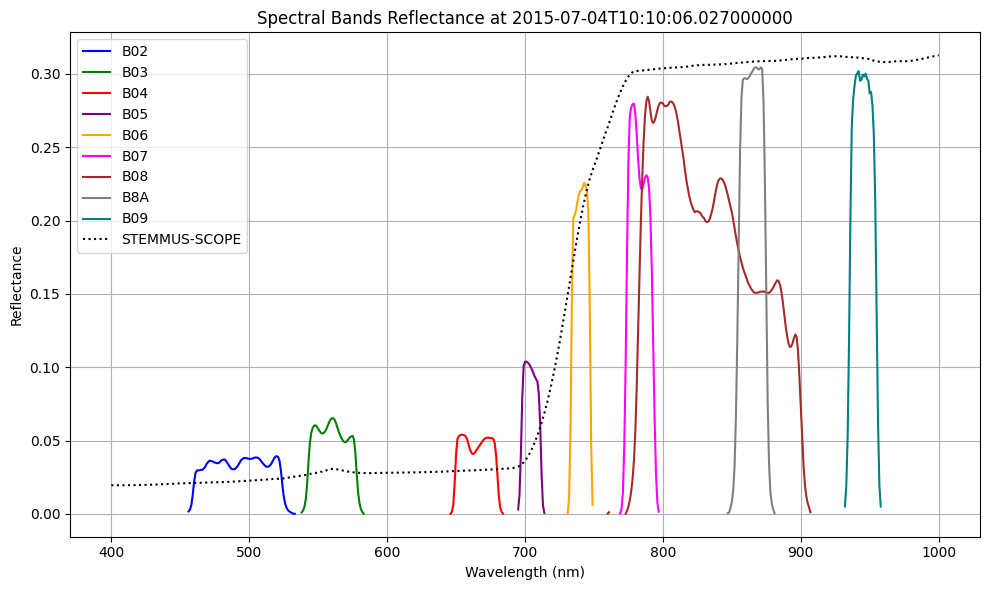

In [97]:

# Safe color map (all lowercase, valid names)
color_map = {
    'B02': 'blue',
    'B03': 'green',
    'B04': 'red',
    'B05': 'purple',
    'B06': 'orange',
    'B07': 'magenta',
    'B08': 'brown',
    'B8A': 'gray',    # use 'gray' instead of 'grey' to be safe
    'B09': 'teal'
}

columns_to_plot = list(color_map.keys())

# Replace 0s with NaN to avoid plotting them
df_plot = df_result.copy()
for column in columns_to_plot:
    if column in df_plot.columns:
        df_plot[column] = df_plot[column].where(df_plot[column] != 0, np.nan)

# Create plot
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    if column in df_plot.columns:
        color = color_map.get(column, 'black')  # fallback to black if undefined
        plt.plot(df_plot['SR_WL'], df_plot[column], label=column, color=color)

# Plot the STEMMUS-SCOPE reflectance
plt.plot(df_plot['SR_WL'], first_index.values, label='STEMMUS-SCOPE', linestyle='dotted', color='black')

# Final touches
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
overpass_time = ds_sentinel2_first_time_step.overpass_time.values.flatten()[0]
plt.title(f'Spectral Bands Reflectance at {overpass_time}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
# Filter the range 400_nm to 500_nm
filtered_data = first_index.loc['400_nm':'500_nm']
filtered_data.index = filtered_data.index.to_series().str.extract(r'(\d+)').astype(int).iloc[:, 0]

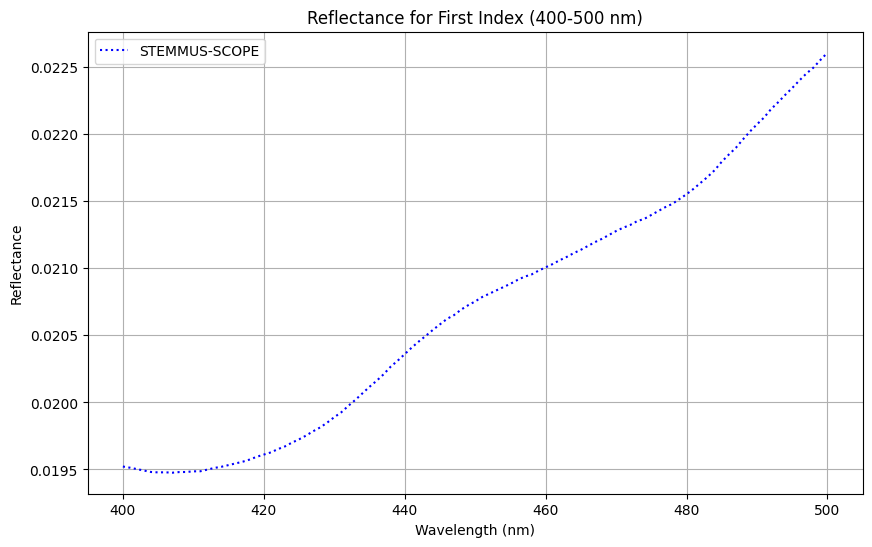

In [71]:

# Plot the filtered data
plt.figure(figsize=(10, 6))

plt.plot(filtered_data.index, filtered_data.values, label='STEMMUS-SCOPE', linestyle='dotted', color='blue')

# Add labels, title, and legend
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Reflectance for First Index (400-500 nm)')
plt.legend()
plt.grid()
plt.show()

Time series of band

In [78]:
# Initialize the DataFrame with SR_WL column
df_result_timeseries_model = pd.DataFrame({'datetime': df_filtered_reflectance.index})

In [79]:
df_spectral_response_sentinel_A_selected = df_spectral_response_sentinel_A[(df_spectral_response_sentinel_A['SR_WL'] >= 400) & (df_spectral_response_sentinel_A['SR_WL'] <= 1000)]

In [80]:
df_spectral_response_sentinel_A_selected.columns

Index(['SR_WL', 'S2A_SR_AV_B1', 'S2A_SR_AV_B2', 'S2A_SR_AV_B3', 'S2A_SR_AV_B4',
       'S2A_SR_AV_B5', 'S2A_SR_AV_B6', 'S2A_SR_AV_B7', 'S2A_SR_AV_B8',
       'S2A_SR_AV_B8A', 'S2A_SR_AV_B9', 'S2A_SR_AV_B10', 'S2A_SR_AV_B11',
       'S2A_SR_AV_B12'],
      dtype='object')

In [76]:
def apply_srf_to_reflectance(
    df_reflectance: pd.DataFrame,
    df_srf: pd.DataFrame
) -> pd.DataFrame:
    """
    Applies spectral response functions to reflectance data to simulate sensor band values.

    Parameters:
    - df_reflectance (pd.DataFrame): DataFrame with datetime index and wavelength columns (e.g. '400_nm', ..., '1000_nm')
    - df_srf (pd.DataFrame): DataFrame with 'SR_WL' and SRF columns for each band.

    Returns:
    - pd.DataFrame: DataFrame with datetime index and simulated band values.
    """
    # Extract wavelengths from df_reflectance columns
    reflectance_wavelengths = np.array([int(col.replace('_nm', '')) for col in df_reflectance.columns])
    srf_wavelengths = df_srf['SR_WL'].values

    # Ensure reflectance and SRF wavelengths match exactly
    if not np.array_equal(reflectance_wavelengths, srf_wavelengths):
        raise ValueError("Wavelengths in reflectance data and SRF do not match.")

    # Convert reflectance DataFrame to NumPy array for performance
    reflectance_array = df_reflectance.values

    # Compute band values
    band_values = {}
    for band in df_srf.columns:
        if band == 'SR_WL':
            continue
        srf = df_srf[band].values
        srf_sum = np.sum(srf)
        if srf_sum == 0:
            band_values[band] = np.nan
            continue
        band_values[band] = (reflectance_array * srf).sum(axis=1) / srf_sum

    # Create result DataFrame
    df_band_values = pd.DataFrame(band_values, index=df_reflectance.index)
    return df_band_values


In [81]:
df_band_values = apply_srf_to_reflectance(df_filtered_reflectance, df_spectral_response_sentinel_A_selected)
print(df_band_values.head())


                     S2A_SR_AV_B1  S2A_SR_AV_B2  S2A_SR_AV_B3  S2A_SR_AV_B4  \
datetime                                                                      
2015-07-04 10:00:00      0.020460      0.022353      0.029011      0.029778   
2015-07-11 10:00:00      0.020381      0.022260      0.028942      0.029555   
2016-05-06 10:00:00      0.028175      0.032757      0.044330      0.050718   
2016-05-09 10:00:00      0.024388      0.027750      0.037334      0.040595   
2016-06-08 10:00:00      0.019129      0.020543      0.026386      0.025942   

                     S2A_SR_AV_B5  S2A_SR_AV_B6  S2A_SR_AV_B7  S2A_SR_AV_B8  \
datetime                                                                      
2015-07-04 10:00:00      0.043960      0.200272      0.301363      0.305925   
2015-07-11 10:00:00      0.043727      0.200219      0.301469      0.306014   
2016-05-06 10:00:00      0.066903      0.203624      0.281148      0.287725   
2016-05-09 10:00:00      0.055947      0.201875    

In [82]:
df_band_values_complete = apply_srf_to_reflectance(df_filtered_reflectance, df_spectral_response_sentinel_A_selected)

In [83]:
band_map = {
    'B02': 'S2A_SR_AV_B2',
    'B03': 'S2A_SR_AV_B3',
    'B04': 'S2A_SR_AV_B4',
    'B05': 'S2A_SR_AV_B5',
    'B06': 'S2A_SR_AV_B6',
    'B07': 'S2A_SR_AV_B7',
    'B08': 'S2A_SR_AV_B8',
    'B8A': 'S2A_SR_AV_B8A',
    'B09': 'S2A_SR_AV_B9',
   
}


In [84]:

def plot_band_comparisons(ds_sentinel2: xr.Dataset, df_band_values: pd.DataFrame, band_map: dict, feature_idx: int = 0):
    """
    Plot Sentinel-2 data vs modeled band values for each band.
    
    Parameters:
    - ds_sentinel2 (xr.Dataset): Sentinel-2 dataset with bands as variables.
    - df_band_values (pd.DataFrame): DataFrame with datetime index and modeled band values.
    - band_map (dict): Mapping from Sentinel-2 band names to modeled band names.
    - feature_idx (int): Index of the feature to plot from Sentinel-2 data.
    """
    overpass_times = pd.to_datetime(ds_sentinel2['overpass_time'].values)

    for s2_band, modeled_band in band_map.items():
        if s2_band not in ds_sentinel2 or modeled_band not in df_band_values.columns:
            continue

        s2_values = ds_sentinel2[s2_band].sel(feature=feature_idx).values * 0.0001
        modeled_values = df_band_values[modeled_band].values

        plt.figure(figsize=(10, 4))
        plt.scatter(overpass_times, s2_values, label='Sentinel-2', marker='o')
        plt.scatter(overpass_times, modeled_values, label='Model Reflectance', marker='x')
        plt.title(f'Band {s2_band} vs {modeled_band}')
        plt.xlabel('Time')
        plt.ylabel('Reflectance')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


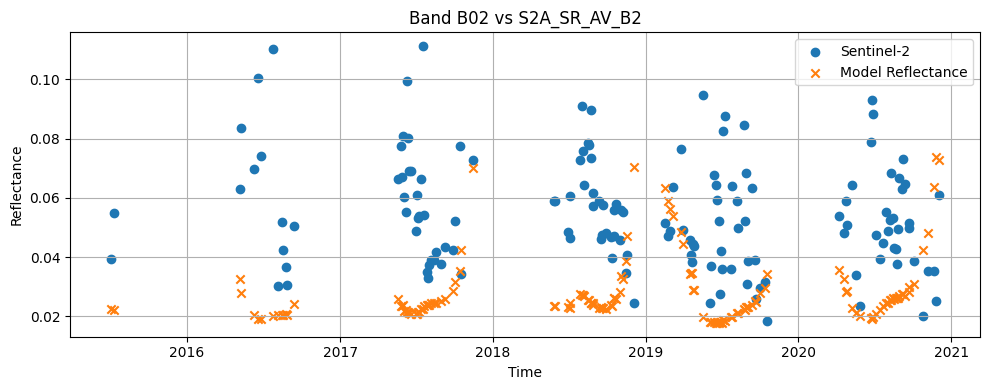

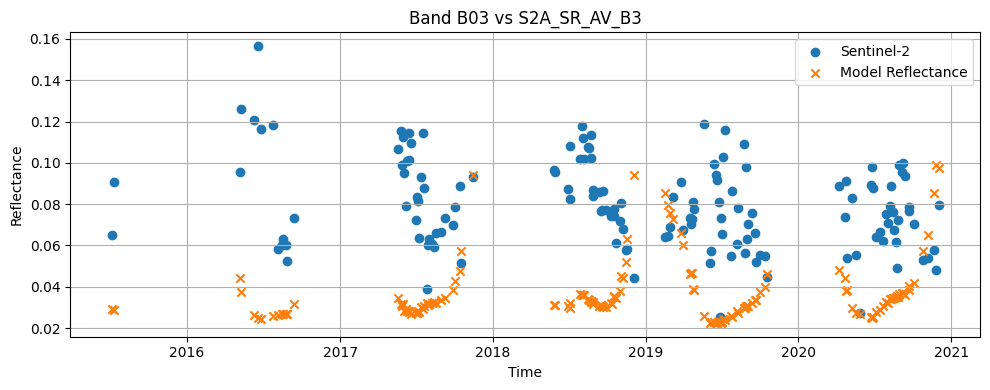

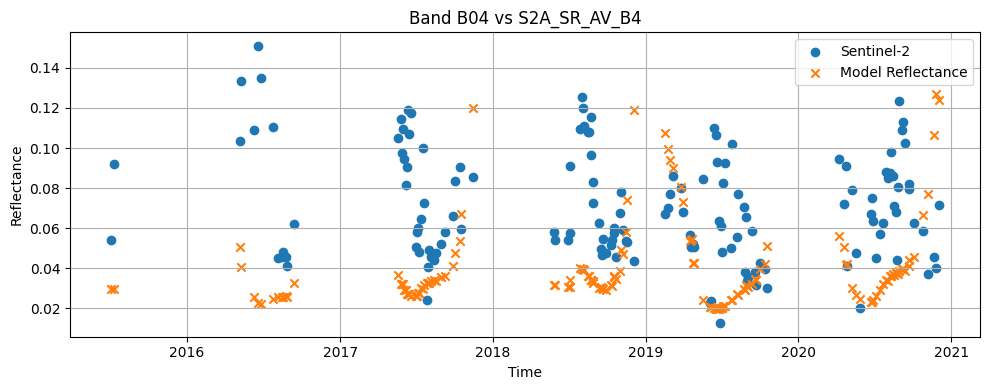

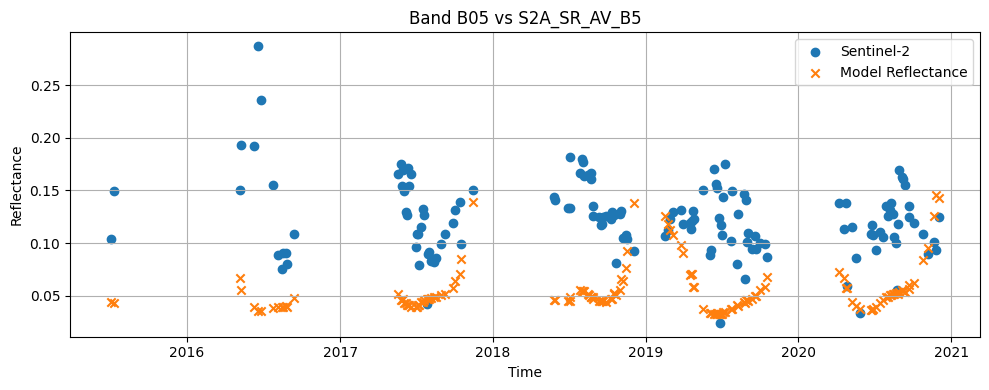

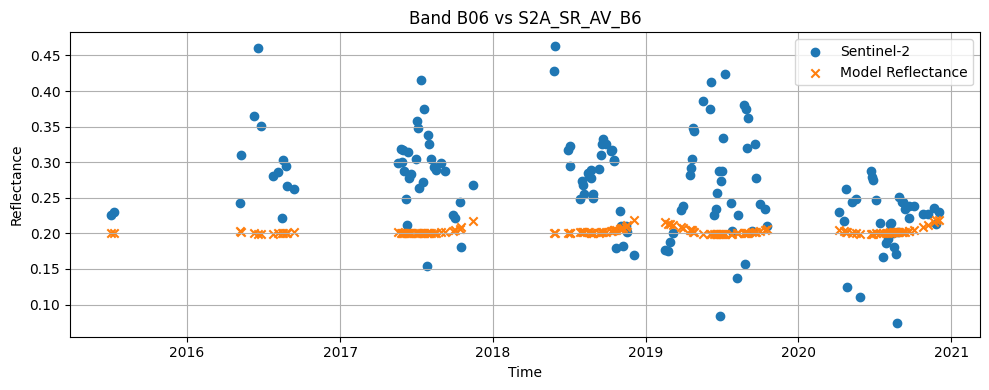

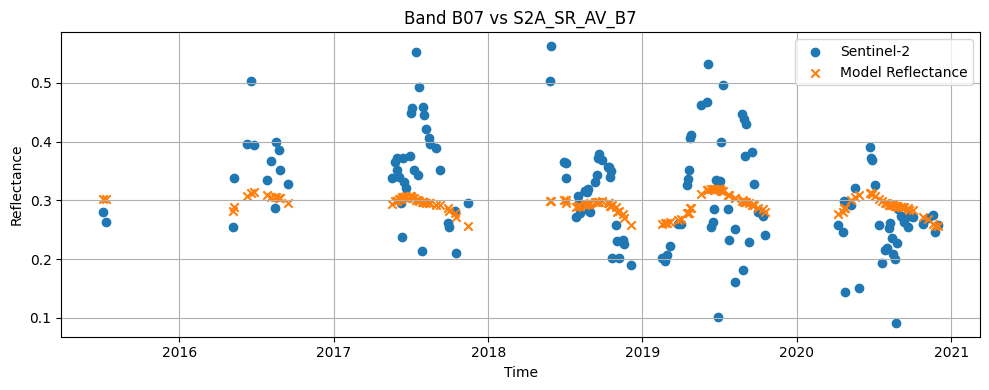

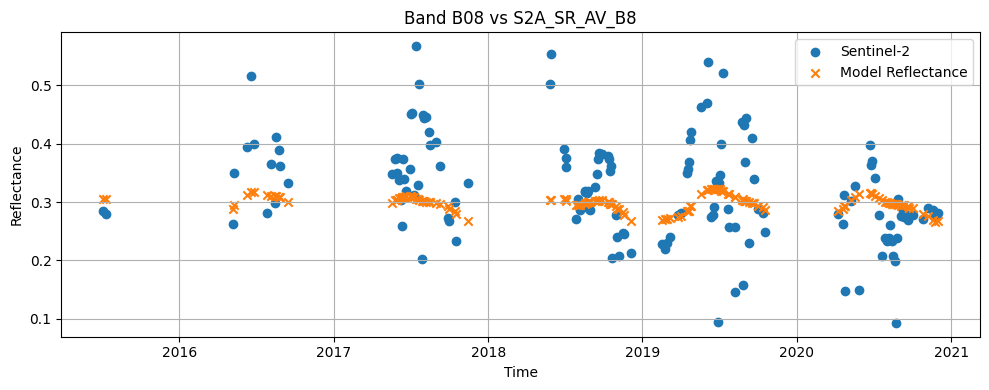

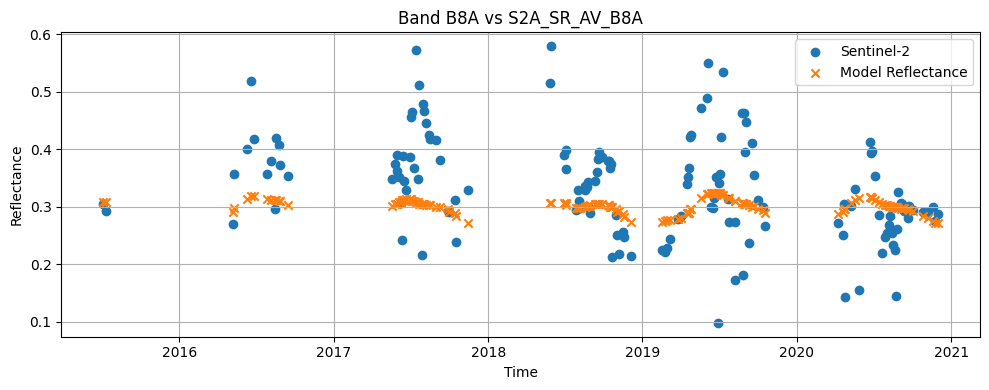

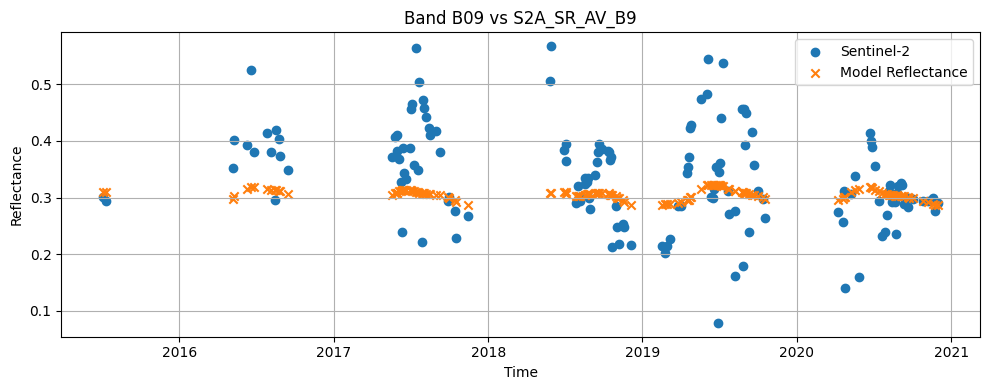

In [85]:
plot_band_comparisons(ds_sentinel2, df_band_values, band_map)


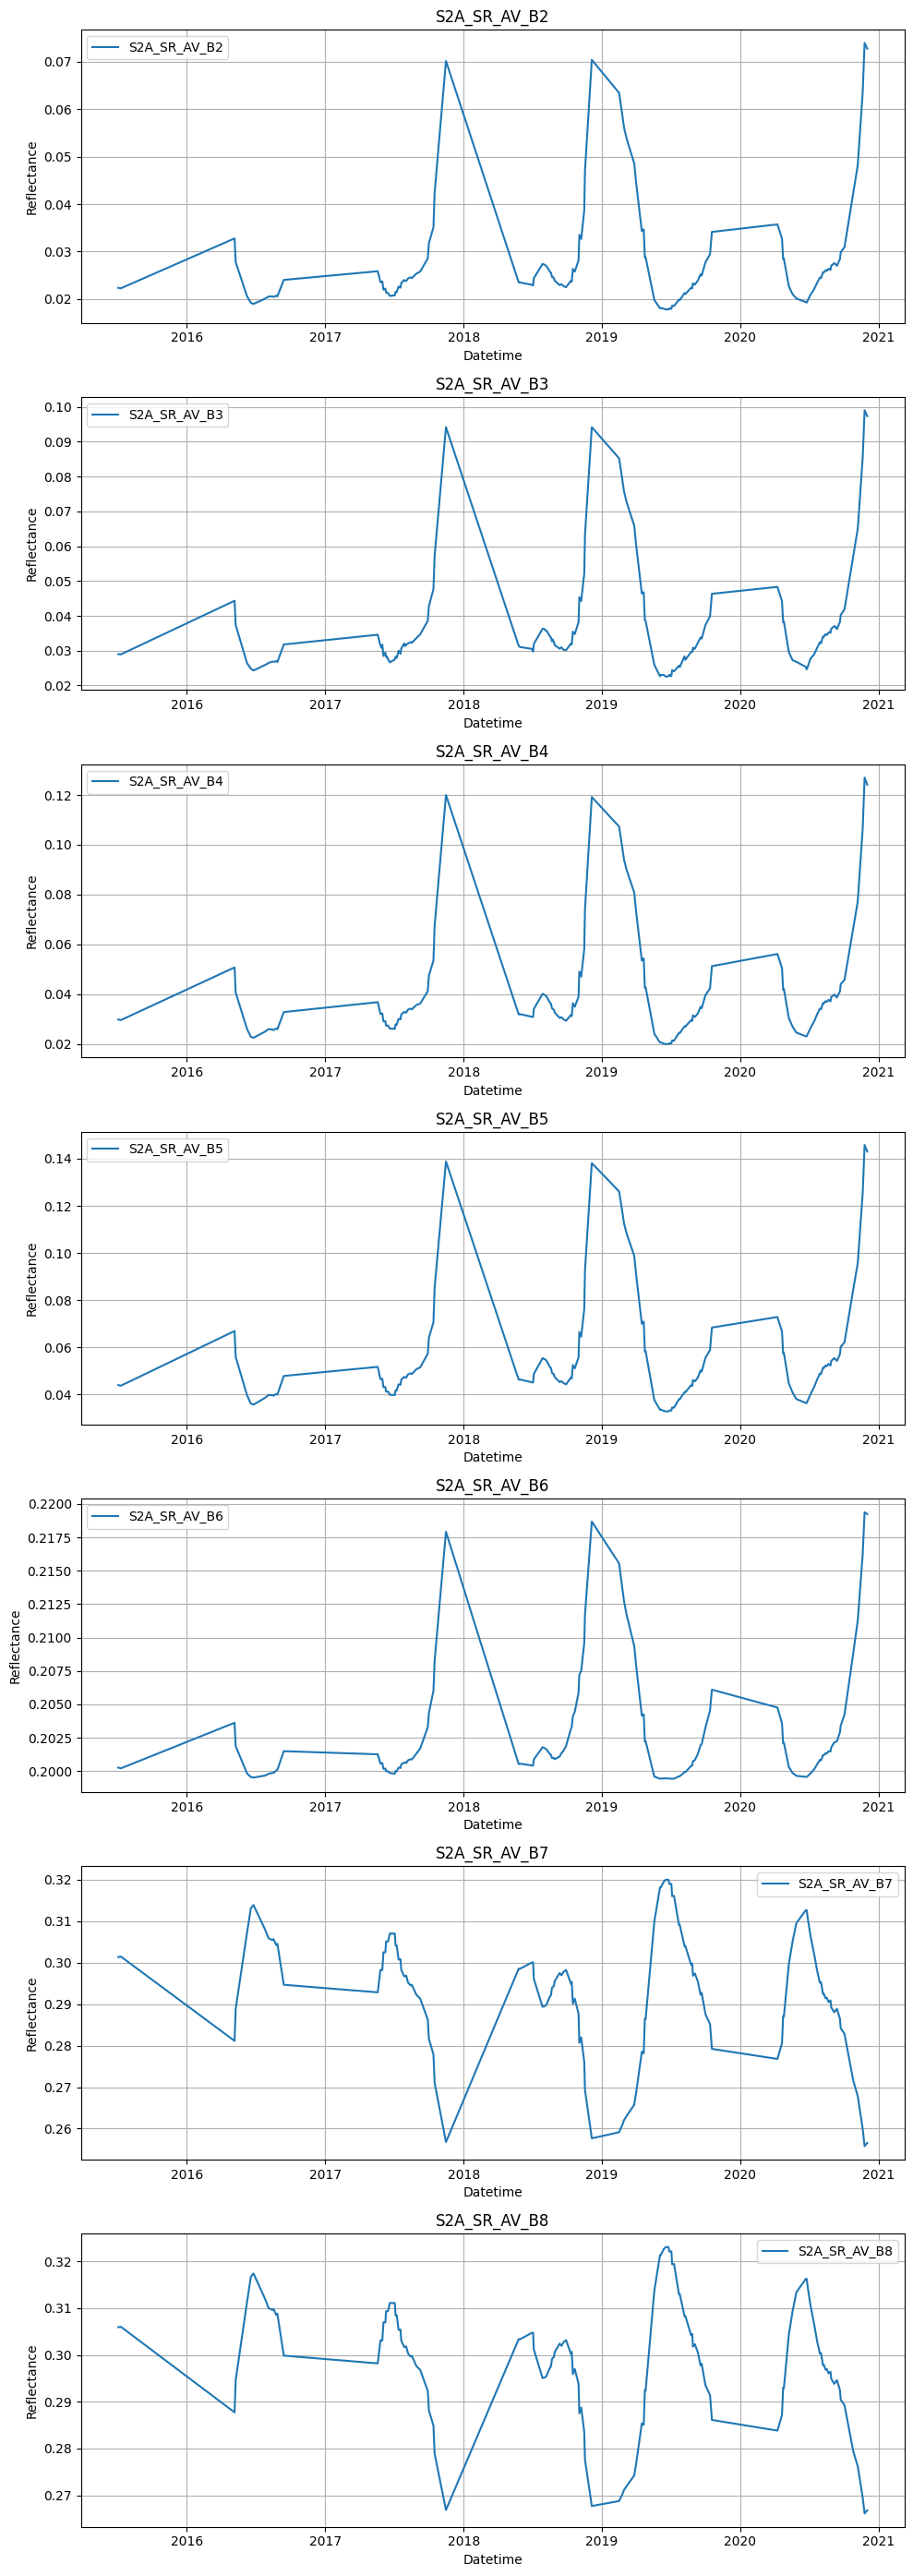

In [86]:


def plot_bands_b2_to_b8(df_band_values_complete):
    """
    Plot the bands S2A_SR_AV_B2 to S2A_SR_AV_B8 from df_band_values_complete for the datetime range 2016-2019.
    Each band will be plotted in a separate row.
    
    Parameters:
    - df_band_values_complete (pd.DataFrame): DataFrame with datetime index and spectral band columns.
    """
    # Filter columns to include only B2 to B8
    bands_to_plot = [f'S2A_SR_AV_B{i}' for i in range(2, 9)]
    df_band_values_filtered = df_band_values_complete[bands_to_plot]

    # Filter the rows to include only data from 2016 to 2019
    # df_band_values_filtered = df_band_values_filtered.loc['2016-01-01':'2016-12-31']

    # Set the figure size based on the number of bands (6 bands in total)
    num_bands = len(df_band_values_filtered.columns)
    fig, axes = plt.subplots(num_bands, 1, figsize=(10, num_bands * 4))

    # If only one subplot, axes is not a 2D array, so handle separately
    if num_bands == 1:
        axes = [axes]

    for idx, band in enumerate(df_band_values_filtered.columns):
        ax = axes[idx]
        ax.plot(df_band_values_filtered.index, df_band_values_filtered[band], label=band)
        ax.set_title(band)
        ax.set_xlabel('Datetime')
        ax.set_ylabel('Reflectance')
        ax.grid(True)
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Call the function to plot the bands
plot_bands_b2_to_b8(df_band_values_complete)
